# MOD510 Project 4

Group 17 members:

- Nidaa Raji 
- Vitalijus Gorbunovas
- Maalidefaa Moses Tantuoyir 



# Abstract

The work done in this project is an extension of the previous project (project 3). However in this project the Random Walking dead algorithm is introduced to model and predict the outbreak of a disease. We also compared this model with a deterministic SI model which we used in project 3. Furthermore, we incorporated an age class (young and old) and used that to estimate the effective rate of infection in the population. The age classes had restrictions imposed to them when it comes to mobility. In the final section of this work, we implemented our own scenarios to see how best we can model this close to a real pandemic.

We estimated a 10% lower mean effective rate of infection when we introduced the age class in this project as compared to the SI model in the previous project. Also, the random walking dead model works better because the effective rate of infection is not considered constant as compared to the compartment model.

In our own implementation of the model, we determined that, our model predicts similar death rate of 0.02 as compared to the COVID 19 death rate of South Africa which we presented in project 3. This is when we assume that there are multiple lockdowns in our model and a deterministic number of infections in an area before a lockdown is imposed.


# Introduction 

This project aims at modeling the spread of of a disease using a different approach than what was used in the previous project. The Random Walking dead algorithm  is introduced to model and predict the outbreak of a disease. 

Modeling the spread of diseases has become very important especially in the current COVID-19 pandemic in which we are experiencing at the moment.  In literature, we generally use statistical and mechanistic modeling methods to either emulate how a disease is expected to spread among a population or use some data to forecast or predict the movement behavior of a particular disease. "At the most basic level, models are either statistical or mechanistic attempts to simulate the disease transmission cycle."<a href="#references"><sup>[1]</sup></a>.  "Mechanistic modeling seeks to emulate the disease transmission process." <a href="#references"><sup>[1]</sup></a> while "Statistical models can’t predict the outcome of relaxing restrictions and a resurgence of the disease, nor can they be adjusted for varying degrees of adherence to social distancing measures." <a href="#references"><sup>[1]</sup></a>.  COVID-19 pandemic modeling is fraught with uncertainties <a href="#references"><sup>[2]</sup></a>.  In the following work, we will use a Monte Carlo and Random Walk (mechanistic approaches) to model the spread of a disease/pandemic in a 2-dimensional space. 

Random Walk Model

In the subsequent exercises a Random walking dead algorithm is implemented. This model assumes that in each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size <a href="#references"><sup>[3]</sup></a>. It is important to note that, a lot of uncertainties are assumed in these simulations because each individual's predisposition to be affected by the spread of the disease in a population is not homogenous. Some of these assumptions are, there is no movement of people between areas when there is a lockdown, random probabilities of symptomatic and asymptomatic people are used with no statistical proof, contact with a dead body do not transmit the disease etc.
The COVID-19 pandemic modeling is fraught with uncertainties <a href="#references"><sup>[2]</sup></a>.

# Setup and configuration

To see an interactive plot, the interactive_plot=True parameter must be specified.

Code example:
<code>
sim = RandomWalkEpidemicSimulator(population_size=683)
sim.simulate(iterations=300,interactive_plot=True)
</code>

In [1]:
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML
import time
import pylab as pl
from IPython import display
import statistics
from numpy.random import default_rng # to generate unique random numbers

In [2]:
# center plot output images
# set .container width to 100% ()
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.container {
    width:100%;
}
</style>
""")

In [3]:
class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.
    Each walker has a disease status which is represented by an
    integer Enum. Also, a set of integer (x, y)-coordinates are
    stored for each walker. The possible coordinates are:
        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction
    It is only possible to move North, South, East, or West. If a
    walker attempts to move outside of the physical domain, nothing
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(
        self,
        population_size,
        no_init_infected=1,
        nx=50,
        ny=50,
        ax=5,
        ay=5,
        q=0.9,
        divide_population=False,
        variable_death_rate=False,
        variable_infection_probabilities=False,
        include_dead=False,
        include_recovered=False,
        include_exposed=False,
        lockdown=False,
        lockdown_delay=30,
        number_of_infectious_in_the_area=10
    ):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction
        :param ny: The number of lattice nodes in the y-direction.
        :param ax: Area size in the x-direction.
        :param ay: Area size in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        :param divide_population: Divide population into different age classes.
        :param variable_death_rate: Use constant or variable death probabilities, i.e. probability is greater for old walkers and lower for young walkers.
        :param variable_infection_probabilities: Assign variable infection probablities based on cautious/reckless and symptomatic/asymptomatic properties.
        :param include_dead: Allow infected walkers to die.
        :param include_recovered: Allow infected walkers to recover.
        :param include_exposed: Allow susceptable walkers to be exposed and get into incubation state.
        :param lockdown: Enforce lockdowns in the areas when number of infectious walkers reaches a certain number.
        :param lockdown_delay: The number of iterations the first lockdown will be delayed after the number of infectious walkers in the area reaches a certain number.
                               The lockdown delay is only applicable for the first lockdown and will not be considered for subsequent lockdowns.
                               Subsequent lockdowns will be enforced immediately after number of infectious walkers reaches a certain number.
                               Note: Lockdown delay represents the hesitation of the goventment to take immediate actions in the beginning of the infection spread.
        :param number_of_infectious_in_the_area: The number of infectious walkers in the area it takes to enforce the lockdown.
        """
        self.pop_ = population_size
        self.I0_ = no_init_infected
        self.nx_ = nx
        self.ny_ = ny
        self.ax_ = 5
        self.ay_ = 5
        self.divide_population_ = divide_population
        self.variable_death_rate_ = variable_death_rate
        self.variable_infection_probabilities_ = variable_infection_probabilities
        self.include_dead_ = include_dead
        self.include_recovered_ = include_recovered
        self.include_exposed_ = include_exposed
        self.lockdown_ = lockdown
        self.lockdown_delay_ = lockdown_delay
        self.number_of_infectious_in_the_area_ = number_of_infectious_in_the_area
        
        # the iteration when the first signs of pandemic detected (no lockdown yet)
        self.pandemic_detected_on_ = None
        
        # random number generator
        self.rng_ = default_rng()
        
        # states
        self.SUSCEPTIBLE_ = 0
        self.EXPOSED_ = 1
        self.INFECTIOUS_ = 2
        self.RECOVERED_ = 3
        self.DEAD_ = 4
        
        # state colors
        self.SUSCEPTIBLE_COLOR_ = 'lightblue'
        self.EXPOSED_COLOR_ = 'orange'
        self.INFECTIOUS_COLOR_ = 'red'
        self.RECOVERED_COLOR_ = 'green'
        self.DEAD_COLOR_ = 'black'
        
        # age classes
        self.OLD_ = 0
        self.YOUNG_ = 1
        
        # death probabilities
        # - default death probability is used when population is not divided
        # - specific death probability is used when population is divided
        self.DEFAULT_DEATH_PROBABILITY_ = 0.05
        self.OLD_DEATH_PROBABILITY_ = 0.1
        self.YOUNG_DEATH_PROBABILITY_ = 0.01
        
        # split population to cautios and reckless
        # - when variable_infection_probabilities is used, population is split into cautious and reckless
        # - cautions population has a lower probability of infecting other walkers
        # - reckless population has a higher probability of infecting other walkers
        self.CAUTIOUS_POPULATION_ = 0.2
        self.RECKLESS_POPULATION_ = 1 - self.CAUTIOUS_POPULATION_
        
        # infection probabilities
        # - the probability for the subject to infect other walkers when in contact
        self.infection_probability_ = q
        self.CAUTIOUS_INFECTION_PROBABILITY_ = 0.3
        self.RECKLESS_INFECTION_PROBABILITY_ = 0.95
        
        # periods
        # - walkers get randomly assigned values from range of incubation and infectious periods
        self.INCUBATION_PERIODS_ = np.arange(start=2, stop=5)
        self.INFECTIOUS_PERIODS_ = np.arange(start=10, stop=15)
        
        # symptomatic and asymptomatic multipliers
        # - probability of a subject to infect other walkers is either increased (asymptomatic) or reduced (symptomatic) 
        self.ASYMPTOMATIC_MULTIPIER_ = 1.05
        self.SYMPTOMATIC_MULTIPIER_ = 0.5
        
        # areas
        # - defining areas in order to be able to enforce the lockdown
        # - array definition: [[x_area_coords, y_area_coords, x_boundaries, y_boundaries, lockdown], ...]
        x_bounds = np.linspace(0, self.nx_, self.ax_+1)
        y_bounds = np.linspace(0, self.ny_, self.ay_+1)
        self.areas_ = []
        for i in range(self.ax_):
            for j in range(self.ay_):
                # populate area
                area = []
                area.append([x_bounds[i], x_bounds[i], x_bounds[i+1], x_bounds[i+1]])
                area.append([y_bounds[j], y_bounds[j+1], y_bounds[j+1], y_bounds[j]])
                area.append([x_bounds[i], x_bounds[i+1]])
                area.append([y_bounds[j], y_bounds[j+1]])
                area.append(False)
                # append area
                self.areas_.append(area)
        
        # nodes
        # - defining noted in order to be more efficiently map walkers' location to the area 
        # - array definition: [[x, y, x+y, area_idx], ...]
        x_node_coords = np.arange(self.nx_+1)
        y_node_coords = np.arange(self.ny_+1)
        nodes = [[x, y, str(x)+','+str(y)] for x in x_node_coords for y in y_node_coords]
        self.nodes_ = []
        for i in range(len(nodes)):
            node = nodes[i]
            node_x = node[0]
            node_y = node[1]
            self.nodes_.append(node)
            for j in range(len(self.areas_)):
                area = self.areas_[j]
                x = area[2] # x_boundaries
                y = area[3] # y_boundaries
                if (
                    ((x[0] < node_x) | ((x[0] == 0) & (node_x == 0))) & (node_x <= x[1]) & # x[0] < pos_x <= x[1]
                    ((y[0] < node_y) | ((y[0] == 0) & (node_y == 0))) & (node_y <= y[1])   # x[0] < pos_y <= y[1]
                ):
                    node.append(int(j))
                    break
        
        self.areas_ = pd.DataFrame(self.areas_, columns=['x_area_coords', 'y_area_coords', 'x_boundaries', 'y_boundaries', 'lockdown'])
        self.areas_.loc[:, ('area_idx')] = self.areas_.index
        self.nodes_ = pd.DataFrame(self.nodes_, columns=['pos_x', 'pos_y', 'pos', 'area_idx'])
        
        # set walkers_
        self.walkers_ = pd.DataFrame(
            columns=[
                'pos_x',                 # x position on the lattice
                'pos_y',                 # y position on the lattice
                'pos',                   # position on the lattice str('{x},{y}')
                #'area_idx',
                #'lockdown', 
                'age_class',             # na, old, young 
                'state',                 # susceptible, exposed, etc.
                'infection_probability', # probability of infecting others (0..1)
                'death_probability',     # probability of dying from the infection (0..1)
                'asymptomatic',          # subject does not show infection symptoms (true, false)
                'incubation_period',     # number of iterations the walker is in EXPOSED_ state 
                'infectious_period',     # number of iterations the walker is in INFECTIOUS_ state
                'exposed_on',            # the iteration the walker was exposed on
                'infectious_on',         # the iteration the walker became infectious
                'recovered_on',          # the iteration the walker recovered
                'dead_on'                # the iteration the walker died
                #'vaccinated_on',         # the iteration the walker gets vaccinated
                #'immune_on'              # the iteration the walker becomes imune
            ],
            index=np.arange(self.pop_)
        )
        
        # set positions
        self.walkers_.loc[:, ('pos_x', 'pos_y')] = np.random.randint(0, [self.nx_, self.ny_], size=(self.pop_, 2))
        self.update_pos()
        
        # set age_class
        if self.divide_population_==True:
            random_idx = self.rng_.choice(self.pop_, size=int(self.pop_/2), replace=False) # unique random idx values
            reminder_idx = np.array(self.walkers_.index)[~np.isin(self.walkers_.index, random_idx)] # reminder idx values
            self.walkers_.loc[random_idx, ('age_class')] = self.OLD_
            self.walkers_.loc[reminder_idx, ('age_class')] = self.YOUNG_
        
        # set asymptomatic
        self.walkers_.loc[:, ('asymptomatic')] = np.random.choice([True, False], self.pop_)
        
        # set infection_probability 
        self.walkers_.loc[:, ('infection_probability')] = self.infection_probability_
        
        if self.variable_infection_probabilities_==True:
            # set infection_probability for cautions and reckless
            cautious_idx = self.rng_.choice(self.pop_, size=int(self.pop_*self.CAUTIOUS_POPULATION_), replace=False) # unique random idx values for cautions population
            reckless_idx = np.array(self.walkers_.index)[~np.isin(self.walkers_.index, cautious_idx)]                # reckless idx values            
            self.walkers_.loc[cautious_idx, ('infection_probability')] = self.CAUTIOUS_INFECTION_PROBABILITY_
            self.walkers_.loc[reckless_idx, ('infection_probability')] = self.RECKLESS_INFECTION_PROBABILITY_
            
            # set infection_probability for asymptomatic and symptomatic
            asymptomatic_idx = self.walkers_[self.walkers_['asymptomatic']==True].index                      # asymptomatic idx values
            symptomatic_idx = np.array(self.walkers_.index)[~np.isin(self.walkers_.index, asymptomatic_idx)] # symptomatic idx values
            self.walkers_.loc[asymptomatic_idx, ('infection_probability')] = self.walkers_.loc[asymptomatic_idx, ('infection_probability')] * self.ASYMPTOMATIC_MULTIPIER_
            self.walkers_.loc[symptomatic_idx, ('infection_probability')] = self.walkers_.loc[symptomatic_idx, ('infection_probability')] * self.SYMPTOMATIC_MULTIPIER_
        
        # set death_probability
        death_probabilities = np.random.randint(1000, size=self.pop_) / 1000 * self.DEFAULT_DEATH_PROBABILITY_
        self.walkers_.loc[:, ('death_probability')] = death_probabilities
        
        if self.divide_population_==True & self.variable_death_rate_==True:
            old_idx = self.walkers_[self.walkers_['age_class']==self.OLD_].index
            self.walkers_.loc[old_idx, ('death_probability')] = np.random.randint(1000, size=len(old_idx)) / 1000 * self.OLD_DEATH_PROBABILITY_
            young_idx = self.walkers_[self.walkers_['age_class']==self.YOUNG_].index
            self.walkers_.loc[young_idx, ('death_probability')] = np.random.randint(1000, size=len(young_idx)) / 1000 * self.YOUNG_DEATH_PROBABILITY_
        
        # set incubation periods
        self.walkers_.loc[:, ('incubation_period')] = np.random.choice(self.INCUBATION_PERIODS_, self.pop_)
        
        # set infectious period
        self.walkers_.loc[:, ('infectious_period')] = np.random.choice(self.INFECTIOUS_PERIODS_, self.pop_)
        
        # iterations
        self.number_of_susceptible_ = np.array([])
        self.number_of_exposed_ = np.array([])
        self.number_of_infectious_ = np.array([])
        self.number_of_recovered_ = np.array([])
        self.number_of_dead_ = np.array([])
        
        self.reset_model()
    
    def reset_model(self): 
        # set state, infection_probability, asymptomatic, exposed_on, infectious_on
        self.walkers_.loc[:, ('state')] = self.SUSCEPTIBLE_
        self.walkers_.loc[:self.I0_-1, ('state', 'exposed_on', 'infectious_on')] = (self.INFECTIOUS_, 0, 0)
        
        # reset iteration values
        self.walkers_.loc[:, ('exposed_on', 'infectious_on', 'recovered_on', 'dead_on')] = (None, None, None, None)
        
        # set positions and areas
        self.update_pos()
        
        # the iteration when the first signs of pandemic detected (no lockdown yet)
        self.pandemic_detected_on_ = None
    
    def update_pos(self):
        """
        Concatenate "pos_x" and "pos_y" columns into a single column "pos" for quicker access.
        """
        self.walkers_.loc[:, ['pos', 'area_idx', 'lockdown']] = (self.walkers_['pos_x'].map(str) + ',' + self.walkers_['pos_y'].map(str), None, None)
        
        if self.lockdown_:
            # drop columns before merge
            self.walkers_ = self.walkers_.drop(columns=['area_idx', 'lockdown'])
            
            # merge (left join) on nodes_ and areas_
            self.walkers_ = self.walkers_.merge(self.nodes_[['pos', 'area_idx']], how='left', on='pos')
            self.walkers_ = self.walkers_.merge(self.areas_[['area_idx', 'lockdown']], how='left', on='area_idx')
    
    def get_betas(self):
        t = np.arange(start=1, stop=len(self.number_of_susceptible_))
        beta_t = -np.concatenate((
            np.array([0]),
             ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))
        beta_mean = statistics.mean(beta_t)
        beta_median = statistics.median(beta_t)
        return beta_mean, beta_median, beta_t
        
    def plot_totals(self):
        fig, ax = plt.subplots()
        
        # susceptible
        ax.plot(self.number_of_susceptible_, label='Susceptible', color=self.SUSCEPTIBLE_COLOR_)
        
        # exposed
        if self.include_exposed_:
            ax.plot(self.number_of_exposed_, label='Exposed', color=self.EXPOSED_COLOR_)
        
        # infectious
        ax.plot(self.number_of_infectious_, label='Infectious', color=self.INFECTIOUS_COLOR_)
        
        # recovered
        if self.include_recovered_:
            ax.plot(self.number_of_recovered_, label='Recovered', color=self.RECOVERED_COLOR_)
        
        # dead
        if self.include_dead_:
            ax.plot(self.number_of_dead_, label='Dead', color=self.DEAD_COLOR_)
        
        # axes
        ax.set_title('Population state change over time')
        ax.set_xlabel('Time (iterations)')
        ax.set_ylabel('Population')
        ax.legend()
        ax.grid()
        
    def save_current_state(self):
        return 0
        
    def simulate(
        self,
        iterations,
        interactive_plot=False
    ):
        """
        Perform a random walk simulation.
        :param iterations: Number of iterations to do in the simulation.
        :param interactive_plot: Display scatter plot after each iteration.
        """
        # reset model
        self.reset_model()
        
        # iterations
        self.number_of_susceptible_ = np.zeros(iterations)
        self.number_of_exposed_ = np.zeros(iterations)
        self.number_of_infectious_ = np.zeros(iterations)
        self.number_of_recovered_ = np.zeros(iterations)
        self.number_of_dead_ = np.zeros(iterations)
        
        self.number_of_susceptible_[0] = self.pop_ - self.I0_
        self.number_of_infectious_[0] = self.I0_
        
        # iterate
        for t in np.arange(iterations):
            self.current_time_ = t
            
            self.move_walkers()
            
            infection_probabilities = np.random.uniform(0, 1, size=self.pop_)
            death_probabilities = np.random.uniform(0, 1, size=self.pop_)
            
            infectious = self.walkers_[self.walkers_['state']==self.INFECTIOUS_]
            
            if self.include_dead_:
                # to-be-dead
                to_be_dead_idx = self.walkers_[
                    (self.walkers_['state']==self.INFECTIOUS_) &                                             # state match
                    (self.walkers_['infectious_on']+self.walkers_['infectious_period']<self.current_time_) & # infectious period surpassed
                    (self.walkers_['death_probability']>death_probabilities)
                ].index
                self.walkers_.loc[to_be_dead_idx, ('state', 'dead_on')] = (self.DEAD_, self.current_time_)
            
            if self.include_recovered_:
                # to-be-recovered
                to_be_recovered_idx = self.walkers_[
                    (self.walkers_['state']==self.INFECTIOUS_) &                                           # state match
                    (self.walkers_['infectious_on']+self.walkers_['infectious_period']<self.current_time_) # infectious period surpassed
                ].index
                self.walkers_.loc[to_be_recovered_idx, ('state', 'recovered_on')] = (self.RECOVERED_, self.current_time_)
            
            if self.include_exposed_:
                # to-be-exposed
                to_be_exposed_idx = self.walkers_[
                    (self.walkers_['state']==self.SUSCEPTIBLE_) &  # state match
                    (self.walkers_['pos'].isin(infectious['pos'])) # pos match
                ].index
                
                # find max probability if there are more than one infectious walker at the node
                to_be_exposed_max_prob = self.walkers_.loc[to_be_exposed_idx, ['pos']].merge(infectious[['pos', 'infection_probability']], how='left', on='pos').groupby(['pos']).max().reset_index()                
                to_be_exposed_max_prob = self.walkers_.loc[to_be_exposed_idx, ['pos']].merge(to_be_exposed_max_prob[['pos', 'infection_probability']], how='left', on='pos')
                to_be_exposed_max_prob = to_be_exposed_max_prob[to_be_exposed_max_prob['infection_probability']>infection_probabilities[to_be_exposed_max_prob.index]]
                
                to_be_exposed_idx = self.walkers_[
                    (self.walkers_['state']==self.SUSCEPTIBLE_) &
                    (self.walkers_['pos'].isin(to_be_exposed_max_prob['pos']))
                ].index
                
                self.walkers_.loc[to_be_exposed_idx, ('state', 'exposed_on')] = (self.EXPOSED_, self.current_time_)
            
            if self.include_exposed_:
                # to-be-infectious
                to_be_infectious_idx = self.walkers_[
                    (self.walkers_['state']==self.EXPOSED_) &                                           # state match
                    (self.walkers_['exposed_on']+self.walkers_['incubation_period']<self.current_time_) # incubation period surpassed
                ].index
            else:
                # to-be-infectious
                to_be_infectious_idx = self.walkers_[
                    (self.walkers_['state']==self.SUSCEPTIBLE_) &  # state match
                    (self.walkers_['pos'].isin(infectious['pos'])) # pos match
                ].index
                
                # find max probability if there are more than one infectious walker at the node
                to_be_infectious_max_prob = self.walkers_.loc[to_be_infectious_idx, ['pos']].merge(infectious[['pos', 'infection_probability']], how='left', on='pos').groupby(['pos']).max().reset_index()                
                to_be_infectious_max_prob = self.walkers_.loc[to_be_infectious_idx, ['pos']].merge(to_be_infectious_max_prob[['pos', 'infection_probability']], how='left', on='pos')
                to_be_infectious_max_prob = to_be_infectious_max_prob[to_be_infectious_max_prob['infection_probability']>infection_probabilities[to_be_infectious_max_prob.index]]
                
                to_be_infectious_idx = self.walkers_[
                    (self.walkers_['state']==self.SUSCEPTIBLE_) &
                    (self.walkers_['pos'].isin(to_be_infectious_max_prob['pos']))
                ].index
                
            self.walkers_.loc[to_be_infectious_idx, ('state', 'infectious_on')] = (self.INFECTIOUS_, self.current_time_)
            
            # totals
            self.number_of_susceptible_[t] = self.walkers_[self.walkers_['state']==self.SUSCEPTIBLE_].shape[0]
            self.number_of_exposed_[t] = self.walkers_[self.walkers_['state']==self.EXPOSED_].shape[0]
            self.number_of_infectious_[t] = self.walkers_[self.walkers_['state']==self.INFECTIOUS_].shape[0]
            self.number_of_recovered_[t] = self.walkers_[self.walkers_['state']==self.RECOVERED_].shape[0]
            self.number_of_dead_[t] = self.walkers_[self.walkers_['state']==self.DEAD_].shape[0]
            
            # lockdown
            if self.lockdown_:
                self.lockdown()
            
            # interactive plot
            if interactive_plot == True:
                self.plot_current_state(interactive_plot=True)
    
    def lockdown(self):
        """
        Check the number of infectious people in the area and lock it down if it is more than 5.
        """
        for i in self.areas_.index:
            area = self.areas_.iloc[i]
            x = area['x_boundaries']
            y = area['y_boundaries']
            
            number_of_infectious = self.walkers_[
                (self.walkers_['state']==self.INFECTIOUS_) &
                ((x[0] < self.walkers_['pos_x']) | ((x[0] == 0) & (self.walkers_['pos_x'] == 0))) & (self.walkers_['pos_x'] <= x[1]) & # x[0] < pos_x <= y[1]
                ((y[0] < self.walkers_['pos_y']) | ((y[0] == 0) & (self.walkers_['pos_y'] == 0))) & (self.walkers_['pos_y'] <= y[1])   # x[0] < pos_y <= y[1]                
            ].shape[0]
            
            if number_of_infectious > self.number_of_infectious_in_the_area_:
                if self.pandemic_detected_on_ == None:
                    self.pandemic_detected_on_ = self.current_time_
                elif self.current_time_ - self.pandemic_detected_on_ > self.lockdown_delay_:
                    self.areas_.loc[i, ('lockdown')] = True
                else:
                    self.areas_.loc[i, ('lockdown')] = False
            else:
                self.areas_.loc[i, ('lockdown')] = False
        
    def move_walkers(self):
        """
        Moves walkers one step at a time
        """
        # possible move directions
        directions = np.array([[0,1], [1,0], [-1,0], [0,-1]])
        
        to_be_moved_idx = self.walkers_.index
        
        # random moves (for the whole population)
        random_moves = np.random.randint(0, 4, len(to_be_moved_idx))
        
        # all future posistions (legal and illegal)
        future_positions = pd.DataFrame(columns=['pos_x', 'pos_y'], index=to_be_moved_idx)
        future_positions.loc[to_be_moved_idx, ('pos_x', 'pos_y')] = self.walkers_.loc[to_be_moved_idx, ('pos_x', 'pos_y')] + directions[random_moves]
        
        # update future positions for old
        if self.divide_population_:
            # possible move directions (for old)
            directions = np.array([[0,1], [1,0], [-1,0], [0,-1], [0,0]])
            
            # to-be-moved
            to_be_moved_idx = self.walkers_[
                (self.walkers_['state']!=self.DEAD_) &
                (self.walkers_['age_class']==self.OLD_)
            ].index
            
            # random moves
            random_moves = np.random.randint(0, 5, len(to_be_moved_idx))
            
            # all future posistions (legal and illegal)
            future_positions.loc[to_be_moved_idx, ('pos_x', 'pos_y')] = self.walkers_.loc[to_be_moved_idx, ('pos_x', 'pos_y')] + directions[random_moves]
        
        # limiting to legal positions
        to_be_moved_idx = future_positions[
            (0 <= future_positions['pos_x']) & (future_positions['pos_x'] <= self.nx_) &
            (0 <= future_positions['pos_y']) & (future_positions['pos_y'] <= self.ny_)
        ].index
        
        # lockdown
        if self.lockdown_:
            future_positions.loc[:, ('pos')] = future_positions['pos_x'].map(str) + ',' + future_positions['pos_y'].map(str)
            future_positions = future_positions.merge(self.nodes_[['pos', 'area_idx']], how='left', on='pos')
            future_positions = future_positions.merge(self.areas_[['area_idx', 'lockdown']], how='left', on='area_idx')
            
            moves_outside_area = [
                (self.walkers_.loc[to_be_moved_idx, ('area_idx')] != \
                 future_positions.loc[to_be_moved_idx, ('area_idx')]) &
                ((self.walkers_.loc[to_be_moved_idx, ('lockdown')] == True) | \
                 (future_positions.loc[to_be_moved_idx, ('lockdown')] == True))
            ]
            
            # 
            moves_outside_area = pd.DataFrame(moves_outside_area).transpose()
            moves_outside_area_idx = moves_outside_area[moves_outside_area[0]==True].index
            
            # remove idx that want to cross the boudaries
            to_be_moved_idx = np.delete(to_be_moved_idx, np.where(to_be_moved_idx.isin(moves_outside_area_idx)))
        
        dead_idx = self.walkers_[
            (self.walkers_['state']==self.DEAD_)
        ].index
        
        to_be_moved_idx = np.delete(to_be_moved_idx, np.where(to_be_moved_idx.isin(dead_idx)))
        
        # updating walkers with legal future positions
        self.walkers_.loc[to_be_moved_idx, ('pos_x', 'pos_y')] = future_positions.loc[to_be_moved_idx, ('pos_x', 'pos_y')]
        self.update_pos()
        
    def plot_current_state(self, interactive_plot=False):
        # 
        susceptible = self.walkers_[self.walkers_['state']==self.SUSCEPTIBLE_]
        exposed = self.walkers_[self.walkers_['state']==self.EXPOSED_]
        infectious = self.walkers_[self.walkers_['state']==self.INFECTIOUS_]
        recovered = self.walkers_[self.walkers_['state']==self.RECOVERED_]
        dead = self.walkers_[self.walkers_['state']==self.DEAD_]
        
        if interactive_plot == True:
            # clear figure before plotting
            plt.clf()
        
        # fill lockdown area
        for i in self.areas_.index:
            area = self.areas_.iloc[i]
            if area['lockdown']:
                plt.fill(area['x_area_coords'], area['y_area_coords'], color='red', alpha=0.2)
        
        # plot
        plt.scatter(susceptible['pos_x'], susceptible['pos_y'], color=self.SUSCEPTIBLE_COLOR_)
        plt.scatter(exposed['pos_x'], exposed['pos_y'], color=self.EXPOSED_COLOR_)
        plt.scatter(infectious['pos_x'], infectious['pos_y'], color=self.INFECTIOUS_COLOR_)
        plt.scatter(recovered['pos_x'], recovered['pos_y'], color=self.RECOVERED_COLOR_)
        plt.scatter(dead['pos_x'], dead['pos_y'], color=self.DEAD_COLOR_)
        
        # axes
        ax = plt.gca().axes
        ax.set_title(f'Random walk simulation (T={self.current_time_+1})')
        
        # due to poor performance, showing axes/grid/lebels/etc. only when interactive_plot is disabled
        if interactive_plot == False:
            # define ticks
            major_xticks = np.arange(0, self.nx_+1, self.nx_/self.ax_)
            major_yticks = np.arange(0, self.ny_+1, self.ny_/self.ay_)
            minor_xticks = np.arange(0, self.nx_+1)
            minor_yticks = np.arange(0, self.ny_+1)
            
            # major ticks
            ax.set_xticks(major_xticks)
            ax.set_yticks(major_yticks)

            # minor ticks
            ax.set_xticks(minor_xticks, minor=True)
            ax.set_yticks(minor_yticks, minor=True)

            # grid
            ax.grid(which='minor', alpha=0.3)
            ax.grid(which='major', alpha=0.7)
            
            # axes limits
            ax.set_xlim(0-1, self.nx_+1)
            ax.set_ylim(0-1, self.ny_+1)
            
            # axes labels
            ax.set_xlabel('x-direction')
            ax.set_ylabel('y-direction')
        
        # clear output and hide axis labels
        if interactive_plot == True:
            # hide axes to improve performance
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            # display figure
            display.display(plt.gcf())
            # clear output (to remove additional figure)
            display.clear_output(wait=True) 
            # sleep
            time.sleep(0.001)
        

# Exercise 1
In the first exercise of the project, we implemeted the random walk model,by running simulations using 10 and 1 initial number of infections and plotting the results of these simulations, we see how the susceptible and infected population are distributed.This shows how the randomness affects the distribution when the intial number of infections is lower.

### Part 1

In [4]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    no_init_infected=1,
    nx=50,
    ny=50
)
sim.simulate(
    iterations=300
)

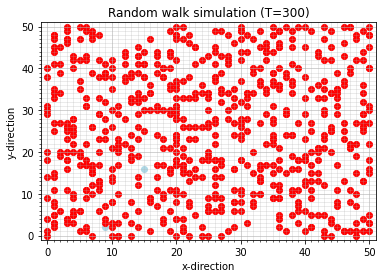

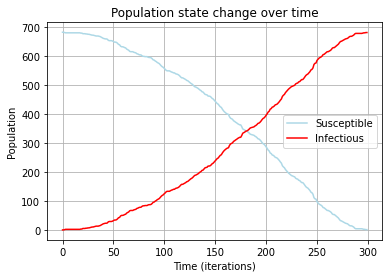

In [5]:
sim.plot_current_state()
sim.plot_totals()

For our 2D plot of 683 people, we simulated for 300 iterations and the results are shown above. In the plot, it shows that, the number of infected people increases slowly in the first 50 iterations and then rises sharply between 50 to 250 interations and then remains constant above this number. Susceptible population decreases slowly for the first 50 iterations, and then decrease sharply  between 50 to 250 iterations and then remains constant. At 150 iterations, the population of susceptible and infected people is the same.  


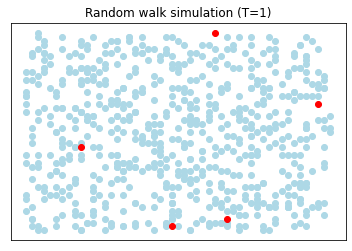

In [6]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    no_init_infected=5,
    nx=50, # 
    ny=50, # 
    ax=10,  # area size in the x-direction
    ay=10,  # area size in the y-direction
    q=0.9,
    divide_population=False,
    variable_infection_probabilities=False,
    include_dead=True,
    include_recovered=True,
    include_exposed=True,
    lockdown=False,
    lockdown_delay=30, # delay initial lockdown for N days after first signs of pandemic have been detected (number of infection in the area reaches number_of_infectious_in_the_area)
    number_of_infectious_in_the_area=10 #
)
sim.simulate(
    iterations=1,
    interactive_plot=True
)

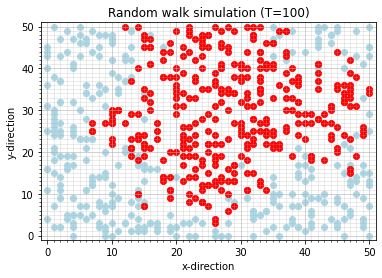

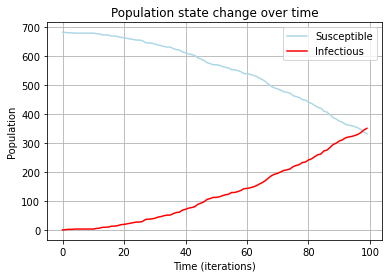

In [7]:
sim = RandomWalkEpidemicSimulator(
    683,
    no_init_infected=1,
    nx=50,
    ny=50,
    q=0.9,
    divide_population=True,
    variable_infection_probabilities=False,
    lockdown=False
)
sim.simulate(
    iterations=100
)
sim.plot_current_state()
sim.plot_totals()


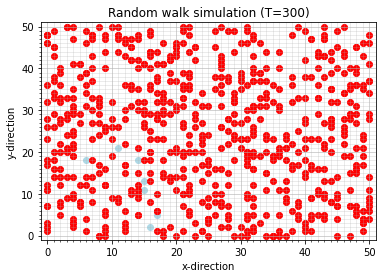

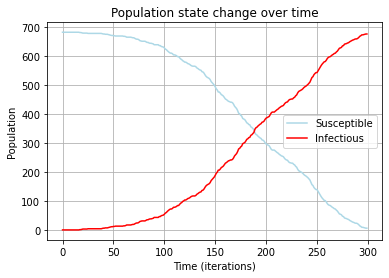

In [8]:
sim = RandomWalkEpidemicSimulator(
    683, nx=50, ny=50, q=0.9, divide_population=False)
sim.simulate(
    iterations=300
)
sim.plot_current_state()
sim.plot_totals()


# Exercise 2

In exercise 2 we implemented the algorithm and we run the simulation where we use 0.9 infection probability and the assumption that the susceptible population never learn after meeting getting infected.
As seen in the plot the beta from the Random walk manifests itself with a lot of variation. However the pattern seems to fit the analytical beta in that it starts from a higher value and decreases as time goes by.

In [9]:
def two_compartment_random_walk(
    # model-specific parameters
    population_size,
    no_init_infected=1,
    nx=50,
    ny=50,
    ax=5,
    ay=5,
    q=0.9,
    divide_population=False,
    variable_death_rate=False,
    variable_infection_probabilities=False,
    include_dead=False,
    include_recovered=False,
    include_exposed=False,
    lockdown=False,
    lockdown_delay=30,
    number_of_infectious_in_the_area=10,
    # simulation-specific parameters
    simulations=100,
    beta=None,
    include_analytical_solution=False,
    iterations=300
):
    """
    Run 2-compartment random walk simulation.
    :param simulations: xxx
    :param beta: xxx
    :param include_analytical_solution: xxx
    :param iterations: xxx
    :param ...: Description for model-specific parameters can be found in RandomWalkEpidemicSimulator class definition.
    """
    # placeholder for all simulations' results
    sims = []
    
    # cumulative values
    susceptible_sum = 0
    infectious_sum = 0
    susceptible_sum_2 = 0
    infectious_sum_2 = 0
    
    # run all simulations
    for i in range(simulations):    
        # running simulation
        sim = RandomWalkEpidemicSimulator(
            population_size=population_size,
            no_init_infected=no_init_infected,
            nx=nx,
            ny=ny,
            ax=ax,
            ay=ay,
            q=q,
            divide_population=divide_population,
            variable_death_rate=variable_death_rate,
            variable_infection_probabilities=variable_infection_probabilities,
            include_dead=include_dead,
            include_recovered=include_recovered,
            include_exposed=include_exposed,
            lockdown=lockdown,
            lockdown_delay=lockdown_delay,
            number_of_infectious_in_the_area=number_of_infectious_in_the_area
        )
        sim.simulate(iterations=iterations)
        sims.append(sim)
        
        # accumulating results from last iterations in each simulation
        susceptible_sum += sim.number_of_susceptible_
        infectious_sum += sim.number_of_infectious_
        susceptible_sum_2 += sim.number_of_susceptible_ ** 2
        infectious_sum_2 += sim.number_of_infectious_ ** 2

    # calculating mean and standard deviation
    susceptible_mean = susceptible_sum / simulations
    infectious_mean = infectious_sum / simulations
    susceptible_stdev = np.sqrt(susceptible_sum_2 / simulations - susceptible_mean ** 2)
    infectious_stdev = np.sqrt(infectious_sum_2 / simulations - infectious_mean ** 2)
    
    plt.plot(np.arange(iterations), susceptible_mean, label='Susceptible', color='b')
    plt.plot(np.arange(iterations), infectious_mean, label='Infectious', color='r')

    plt.fill_between(
        np.arange(iterations),
        susceptible_mean-susceptible_stdev,
        susceptible_mean+susceptible_stdev,
        color='gray',
        alpha=0.3
    )
    plt.fill_between(
        np.arange(iterations),
        infectious_mean-infectious_stdev,
        infectious_mean+infectious_stdev,
        color='gray',
        alpha=0.3
    )
    
    # placeholder of beta_means
    beta_means = []
    
    # 
    if include_analytical_solution==True:
        if type(beta)==int or type(beta)==float:
            pass
        elif type(beta)==str:
            if beta=='mean':
                for sim in sims:
                    beta_mean, beta_median, beta_t = sim.get_betas()
                    beta_means.append(beta_mean)
                beta = statistics.mean(beta_means)
            else:
                raise Exception("Beta must be str('mean').")
        else:
            raise Exception("Beta must be int, float or str.")
        S0=population_size
        I0=no_init_infected
        t=np.arange(iterations)
        susceptible=((S0+I0)*(S0/I0)*np.exp(-beta*t))/(1+(S0/I0)*np.exp(-beta*t))
        infectious=(S0+I0)/(1+(S0/I0)*np.exp(-beta*t))
        plt.plot(t, susceptible, label=f'Susceptible (Analytical, beta={beta})', color='b', alpha=0.5, dashes=[4, 1])
        plt.plot(t, infectious, label=f'Infectious (Analytical, beta={beta})', color='r', alpha=0.5, dashes=[4, 1])
        
    plt.title(f'Results from {simulations} random-walk simulation (T={iterations})')
    plt.xlabel('Time (iterations)')
    plt.ylabel('Population')
    plt.grid()
    plt.legend()
    plt.show()
    
    return iterations, sims, susceptible_mean, infectious_mean, susceptible_stdev, infectious_stdev, beta_means


### Part 1

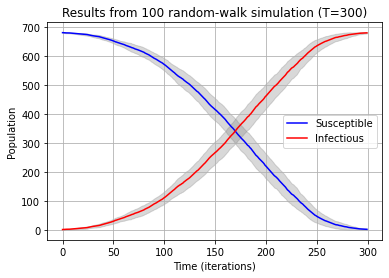

In [10]:
e2p1_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100
)

After a minimum of 100 smulations and 300 iterations, we observed that the sample mean for the susceptible population decreases with an increase in the number of iterations. The sample mean of the infectious population increases with an increase in the number of iterations. The sample standard deviation in both scenarios increases slowly with an increase in the number of iterations but reduces at from about 270 iterations. It takes approximately 160 iterations for the sample means of the susceptible and infectious population to be equal. This case is for an assuption that, only 1 person is infected in the population and every person behaves the same.


### Part 2

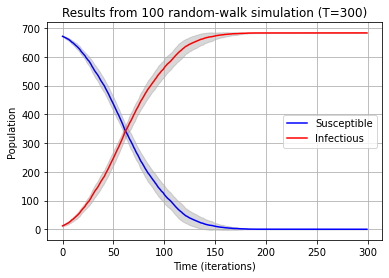

In [11]:
e2p2_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=10,
    iterations=300,
    simulations=100
)

As we increase the number of infected people to 10, it takes a fewer iterations of 60, to equalize the means of the susceptible and infectious sample population. The is a sharp decline in the sample mean of the susceptible population and vice versa for the infectious population. The standard deviations seem a bit lower in this case than the previous case discussed above.

### Part 3

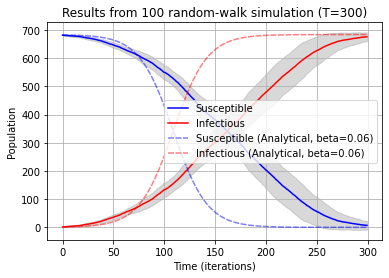

In [12]:
e2p3_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100,
    include_analytical_solution=True, # use sz model from project 3
    beta=0.06
)

From the last assignment, the effective rate of infection was 0.06.  In comparition with the random walk model as shown above, the effective rate of infection is lower. We got an approximate value of about 0.054 for the effective rate of infection. This means that, it takes longer for the whole population to be infected when we use the random walk approach.

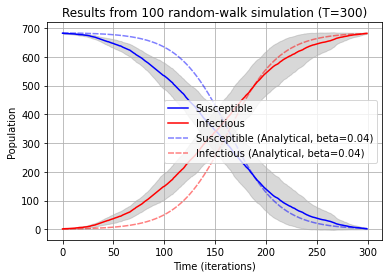

In [13]:
e2p3_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100,
    include_analytical_solution=True, # use sz model from project 3
    beta=0.04
)

We simulated a best fit to see determine at what effective rate of infection will the population get equal number of susceptible and infectious population at the same number of iterations, in bothanalytical solution and random walk approach. The plot above shows that, the best effective rate of infection should be 0.045

In [14]:
infectious_mean = e2p1_results[3]

In [15]:
def get_beta(population_size, infectious_mean, number_of_infectious):
    """
    Calculate beta.
    :param population_size: The size of the population.
    :param infectious_mean: The mean of infectious population???
    :param number_of_infectious: Initial number of infectious walkers.
    """
    number_of_susceptible = population_size - number_of_infectious
    t = np.arange(0, len(infectious_mean), 1)
    return (-np.log((number_of_infectious/number_of_susceptible)*(population_size-infectious_mean)/infectious_mean)/t)

solutions = get_beta(683, infectious_mean, 1)
np.mean(solutions[1:])

<ipython-input-15-aa9a137b99f5>:11: RuntimeWarning: divide by zero encountered in true_divide
  return (-np.log((number_of_infectious/number_of_susceptible)*(population_size-infectious_mean)/infectious_mean)/t)


0.05446964574474906

The mean number of infectious people that describes our beta function as a fuction of time is 0.0546

# Exercise 3
In exercise 3 we divide the population in to old and and young, furthermore a movement behaviour for the old humans is considered where they have the probability of staying where they are in addition to the four directions of choice. In this simulation, we see that the old humans survive than the young humans, this could be due to the movement pattern of the old humans which gives them less probability of getting infected than the young humans do.

### Part 1

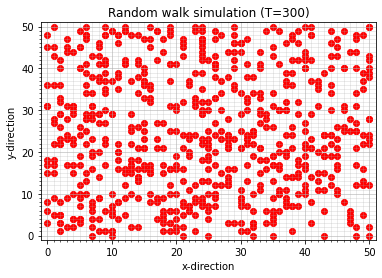

In [16]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    nx=50,
    ny=50,
    q=0.9
)
sim.simulate(
    iterations=300
)
sim.plot_current_state()

In [17]:
beta_mean, beta_median, beta_t = sim.get_betas()
beta_mean, beta_median

<ipython-input-3-da5da319be23>:282: RuntimeWarning: divide by zero encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))
<ipython-input-3-da5da319be23>:282: RuntimeWarning: invalid value encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))


(nan, 0.043171837505723405)

From our simulations, when everyone has the infection, then there is no effective rate of infection. When the effective rate of infection is higher than a value of 0.045(previous value), everyone is infected. Also, when we simuate and the rate is lower than 0.045, thn there are still some uninfected or susceptible people in the population.

<ipython-input-3-da5da319be23>:282: RuntimeWarning: divide by zero encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))
<ipython-input-3-da5da319be23>:282: RuntimeWarning: invalid value encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))


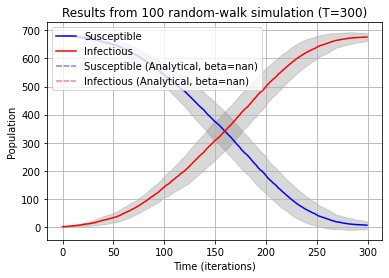

In [18]:
e3p1_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100,
    include_analytical_solution=True, # sz model from project 3
    beta='mean'
)

### Part 2

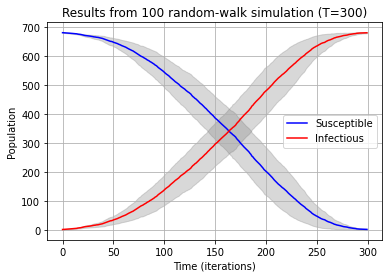

In [19]:
e3p2_results_1 = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100
)

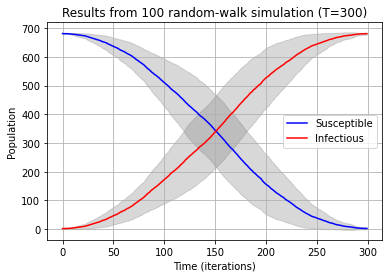

In [20]:
e3p2_results_2 = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100,
    divide_population=True
)

From the above plots,the disease spreads faster when the population is divided.

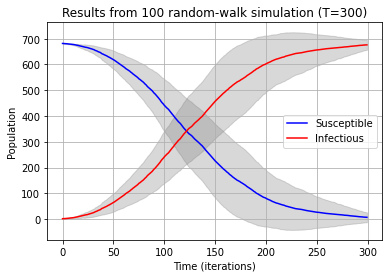

In [21]:
e3p2_results = two_compartment_random_walk(
    population_size=683,
    no_init_infected=1,
    iterations=300,
    simulations=100,
    divide_population=True,
    variable_death_rate=True
)

<ipython-input-3-da5da319be23>:282: RuntimeWarning: divide by zero encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))
<ipython-input-3-da5da319be23>:282: RuntimeWarning: invalid value encountered in true_divide
  ((self.number_of_susceptible_[t] - self.number_of_susceptible_[t-1]) * self.pop_) / (self.number_of_susceptible_[t] * self.number_of_infectious_[t])))


(nan, 0.02772187580842276)

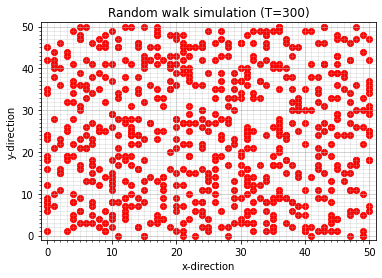

In [22]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    nx=50,
    ny=50,
    q=0.9,
    divide_population=True
)
sim.simulate(
    iterations=300
)
sim.plot_current_state()
beta_mean, beta_median, beta_t = sim.get_betas()
beta_mean, beta_median

The mean effective rate of infection is lower in this scenario as compared to the previous project with zombies. The walkers spread faster.

# Exercise 4
In exercise 4, a number of uncertainties are introduced; division of the population(old and young), variable infection probability, variable death rate, dead, exposed and recovered population. Lockdown scenario, lockdown delay, number of infections in an area before later lockdowns are imposed.

We did a number of simulations while varying these uncertainties. In general, different results are achieved in each run because of the random movement in the model. There is also, a quick recovery of people and a higher number of death if the lockdown is delayed.

We have considered an incubation period of 2 to 4 days that is also out latency period. This means that the individual becomes infectious at the end of the incubation period. The person infected can be symptomatic or asymptomatic and that implies that the probability of them infecting others will increase or decrease accordingly. Asymptomatic multiplier is 1.05 as the risk is higher when someone is not aware of their infection. For the symptomatic people we multiply the infection probability by 0.5 for the opposite reason. These two cases are then divided into two groups, of reckless and cautious people. Cautious people infection spread probability is set to 0.3 while the reckless have a 0.95 spread of infection probability. We also set the recovery rate for young people to 0.99 while it is 0.9 for old people. The outcome is either recovery or death, so the probabilities of death for each group is complementary. The diagram is a visual of the possibilities.

![Explanation of our Implementation](img1.png)

Following is a simulation with lockdown.

In [23]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    no_init_infected=5,
    nx=50,
    ny=50,
    ax=10,
    ay=5,
    q=0.9,
    divide_population=True,
    variable_infection_probabilities=False,
    variable_death_rate=True,
    include_dead=True,
    include_recovered=True,
    include_exposed=True,
    lockdown=True,
    lockdown_delay=10,
    number_of_infectious_in_the_area=10 #
)
sim.simulate(
    iterations=300
)

6.0

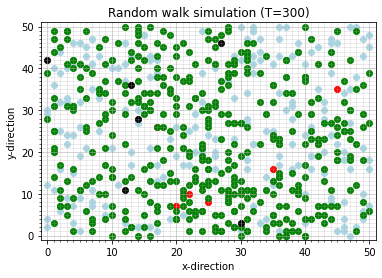

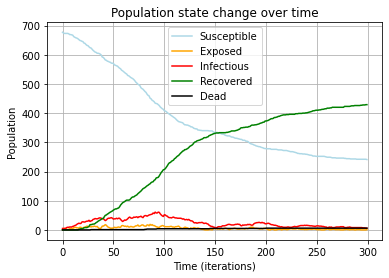

In [24]:
sim.plot_current_state()
sim.plot_totals()
sim.number_of_dead_[-1]

Following is a simulation without lockdown.

In [25]:
sim = RandomWalkEpidemicSimulator(
    population_size=683,
    no_init_infected=5,
    nx=50,
    ny=50,
    ax=10,
    ay=5,
    q=0.9,
    divide_population=True,
    variable_infection_probabilities=True,
    variable_death_rate=True,
    include_dead=True,
    include_recovered=True,
    include_exposed=True,
    lockdown=False,
    lockdown_delay=10,
    number_of_infectious_in_the_area=10 
)
sim.simulate(
    iterations=300
)

11.0

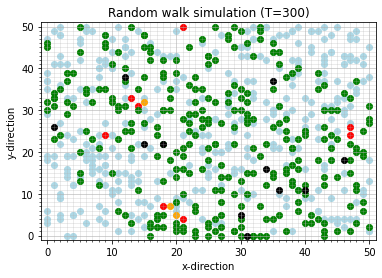

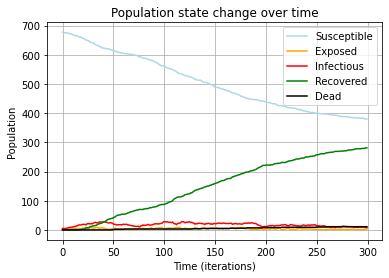

In [26]:
sim.plot_current_state()
sim.plot_totals()
sim.number_of_dead_[-1]

We compared our case to South Africa which recorded a low death rate in the previous assignment. The death rate in this country is at 0.0265 with an effective infection rate of 0.513. In our model, we introduced a lockdown of 30 days(iterations) and introduced the number of infections in an area before a second lockdown to 10 days, and we got a similar death rate of about 0.02. However, we are dealing with a smaller population and area in our case and the random/uncontrolled movement of people. It however, helps in understand the various scenarios in case of a lockdown in any country.

# Discussions
The Random Walking dead model shows a high standard deviation for both susceptible and infectious population when the number of initially infected people is higher. That is, the higher the number of initially infected people, the higher the standard deviation in the model. When the model behaves like the SI model in the previous assignment when similar beta values are used, and the no assumptions are considered.

When different assumptions like lockdowns are considered, we begin to get different death rate predictions as we increase the number of iterations. The mean of the effective rate of infections for a number of simulations, however, tells us approximately the estimates (susceptible, infected, dead etc.) we can get for a particular population. The same can be said of the standard deviation.


# Reflections

This was a harder project as compared to the previous projects especially when it comes to coding it and taking into place some assumptions.

In future projects, we will suggest that, some realistic or approximate values are provided for us to use when it comes a case implementation like exercise 4. For example, providing a value for latency period, how many people should recover or die from the population, percentage of peole who should probably be asymtomatic or symtomatic etc. 

This is because an open question like this makes it hard for us to present it and discuss all the possible scenarios and even much harder to use some realistic assumptions for our simulations. 

However, this was a great exercise for us as it is very relatable especially in the current pandemic.

# Conclusion 

In our analysis, the random walk model provides a good way to visualize the spread of a disease in a population as compared to the SEIRD model we used in the previous project.  There are, however, a lot of assumptions that were taken into place and that provides uncertainties in real life scenarios.  Various scenarios affect how a disease spreads in a population. It is a bit difficult to quantify an uncertainty like ‘lockdown’ in a population. It is more realistic that, there are still people who move around during the lockdown. The strictness or lockdown rules are also different. We therefore conclude that, the random walk model implemented is better than the previous SEIRD model in modeling the spread of a disease but a combination of this model with a statical method would help in understanding a pandemic situation, for example, COVID 19. In conclusion, we should not forget that a model is made not to say what will happen in the future, but to see what could do, and try and do something about it <a href="#references"><sup>[4]</sup></a>.

<span id="references"></span>
# References


1. Kramer, D. (2020). COVID-19 pandemic modeling is fraught with uncertainties. Physics Today, 73(6), 25–27. https://doi.org/10.1063/PT.3.4493


2. COVID-19 pandemic modeling is fraught with uncertainties https://physicstoday.scitation.org/doi/10.1063/PT.3.4493

    
3. Notes on the random walk model, Robert Nau, Fuqua School of Business, Duke University
https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf


4. Alessandro Comunian, Romina Gaburro, Mauro Giudici,
Inversion of a SIR-based model: A critical analysis about the application to COVID-19 epidemic,
Physica D: Nonlinear Phenomena,
Volume 413,
2020,
132674,
ISSN 0167-2789,
https://doi.org/10.1016/j.physd.2020.132674.


